In [1]:
set.seed(2004)

# Table of Contents
- [Introduction](#Introduction)
- [EDA](#EDA)
- [Data cleaning](#Data_cleaning)
- [Model Training](#MODEL_TRAINING)
- [Evaluation](#Evaluation)
- [Conclusion](#Conclusion)

In [48]:
install.packages("car")


The downloaded binary packages are in
	/var/folders/pp/nms3rb9s3lx8dj72smlll5440000gn/T//Rtmp8jMESB/downloaded_packages


In [49]:
library(tidyverse)
library(repr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(tidymodels)
library(caret)
library(e1071)
library(rpart)
library(car)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




# Introduction

In this study, we utilize the UCI Adult Census Salary dataset, which gathers demographic and employment-related information from the 1994 U.S. census.

The dataset comprises 15 variables, encompassing both numerical and categorical types, to capture a comprehensive snapshot of the American workforce during that time. The numerical variables include age, final weight (fnlwgt) representing the number of people in the U.S. someone symbolizes, education-num reflecting the total years of education, capital-gain and capital-loss indicating financial earnings or losses from investments outside of work, and hours-per-week detailing work hours. Categorical variables encompass workclass, education, marital status, occupation, relationship, race, sex, native country, and salary, with the latter serving as the prediction target to determine if an individual's annual income exceeds $50,000.

The motivation behind analyzing this dataset stems from a desire to understand the critical factors influencing income levels and to identify potential biases in income distribution across different demographic groups, such as gender and race. Additionally, this analysis aims to detect workforce trends, such as variations in education level distributions across different occupations. By employing different techniques and algorithms in data science, this project seeks to predict whether an individual will earn more than $50,000 per year based on their attributes within the dataset. This investigation not only contributes to a deeper understanding of the economic and social dynamics of the 1990s American workforce but also enhances our knowledge of applying data science methodologies in real-world socioeconomic research.


In [3]:
# Read the adult.data file
# The `adult.names` file typically contains information on the attributes and you need to specify them manually
column_names = c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
                 "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", 
                 "income")

adult_data <- read.csv("~/Downloads/adult (1)/adult.data", header = FALSE, sep = ",", col.names = column_names, na.strings = " ?")

# Check the first few rows of the data
head(adult_data)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
nrow(adult_data)

[1] 32561

# EDA


### Figure1. Age vs number of people who receive income > 50k by different sex group


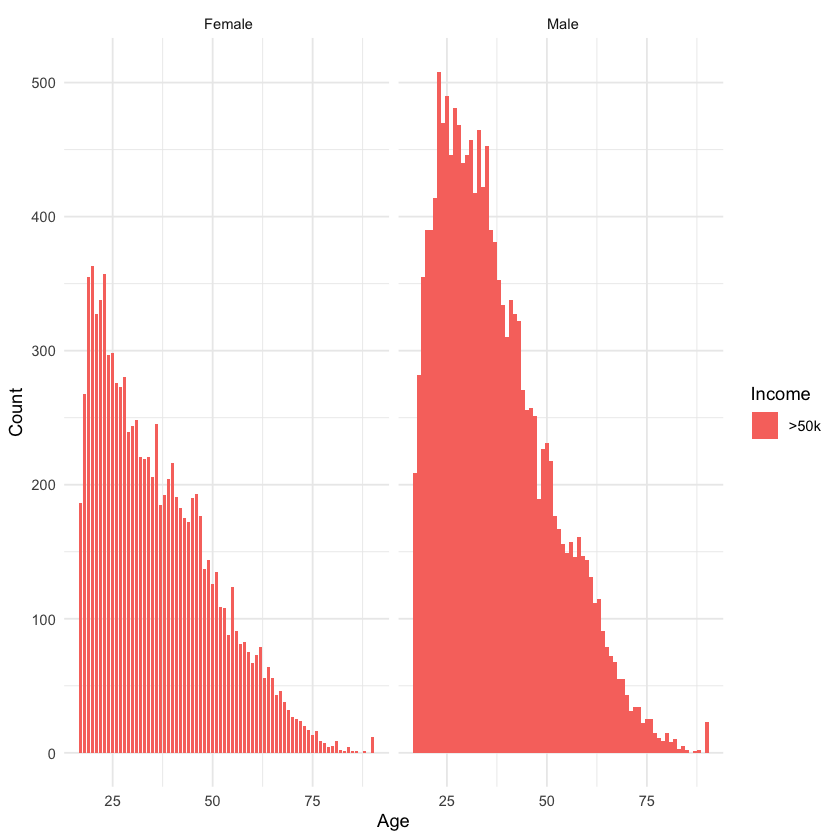

In [5]:
summary_data <- adult_data %>%
    group_by(age, sex, income) %>%
    summarise(count = n(), .groups = 'drop') %>%
    mutate(income = ifelse(income == 0, "<=50k", ">50k"))

ggplot(summary_data, aes(x = age, y = count, fill = income)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(. ~ sex) +
    labs(x = "Age", y = "Count", fill = "Income") +
    theme_minimal()


In [6]:
head(summary_data)

age,sex,income,count
<int>,<chr>,<chr>,<int>
17,Female,>50k,186
17,Male,>50k,209
18,Female,>50k,268
18,Male,>50k,282
19,Female,>50k,355
19,Female,>50k,1


### Figure2. Education vs number of people who receive income > 50k

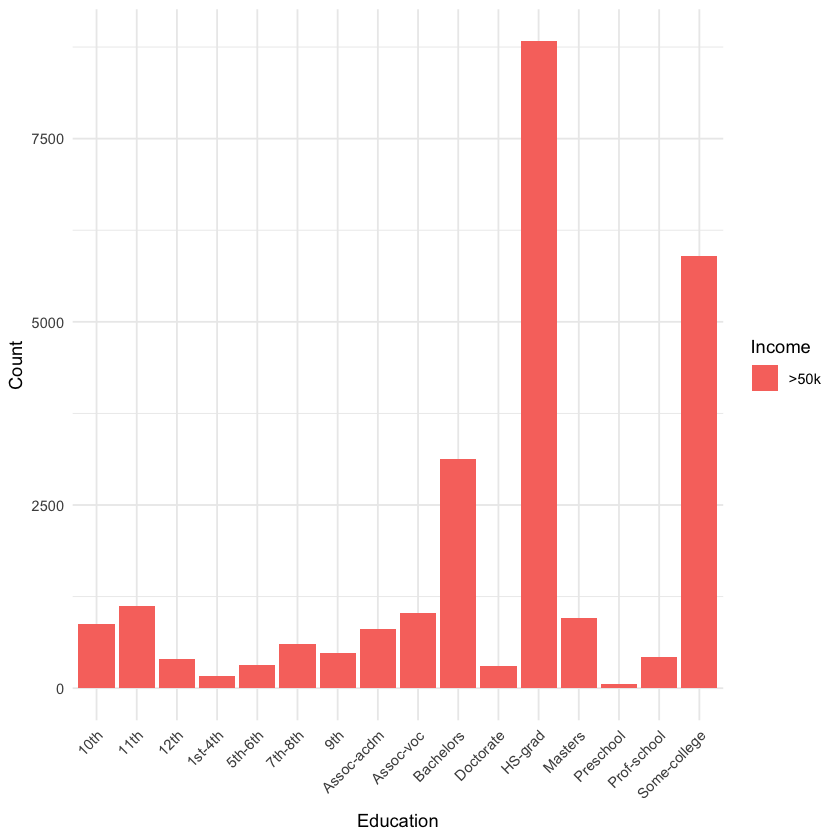

In [7]:
summary_data <- adult_data %>%
    group_by(education, income) %>%
    summarise(count = n(), .groups = 'drop') %>%
    mutate(income = ifelse(income == 0, "<=50k", ">50k"))
ggplot(summary_data, aes(x = education, y = count, fill = income)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Education", y = "Count", fill = "Income") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Combine theme settings


### Figure 3: Race vs Number of People Colored by Income of Different Sex Groups

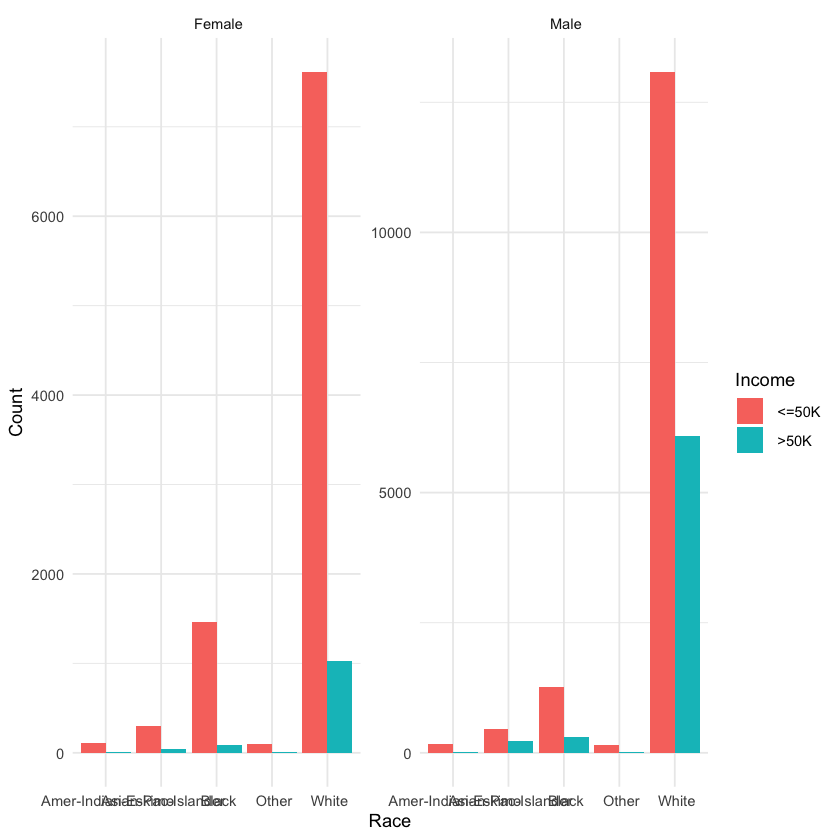

In [8]:
summary_data <- adult_data %>%
  group_by(race, sex, income) %>%
  summarise(count = n(), .groups = 'drop') # Drop the grouping

# Plotting the data
ggplot(summary_data, aes(x = race, y = count, fill = income)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~sex, scales = "free") +
  labs(x = "Race", y = "Count", fill = "Income") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme_minimal()

### Figure 4: Sex vs Number of People Represented (fnlwgt) Colored by Income


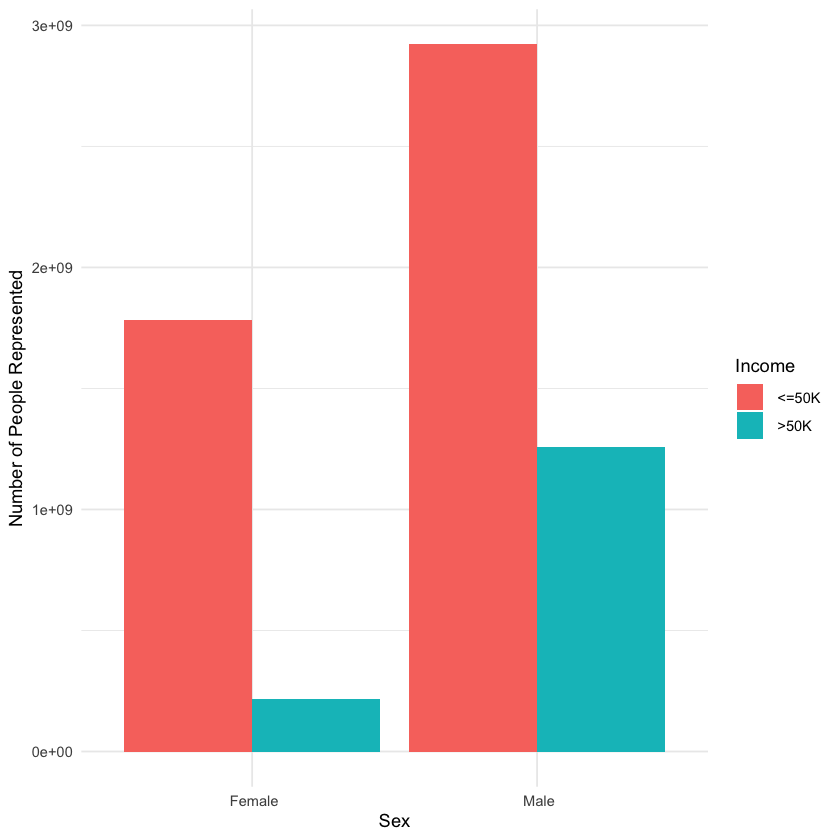

In [9]:
fnlwgt_data <- adult_data %>%
  group_by(sex, income) %>%
  summarise(total_fnlwgt = sum(fnlwgt), .groups = 'drop') # Sum fnlwgt and drop the grouping

# Plotting the data
ggplot(fnlwgt_data, aes(x = sex, y = total_fnlwgt, fill = income)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Sex", y = "Number of People Represented", fill = "Income") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme_minimal()

`summarise()` has grouped output by 'education_num'. You can override using the
`.groups` argument.


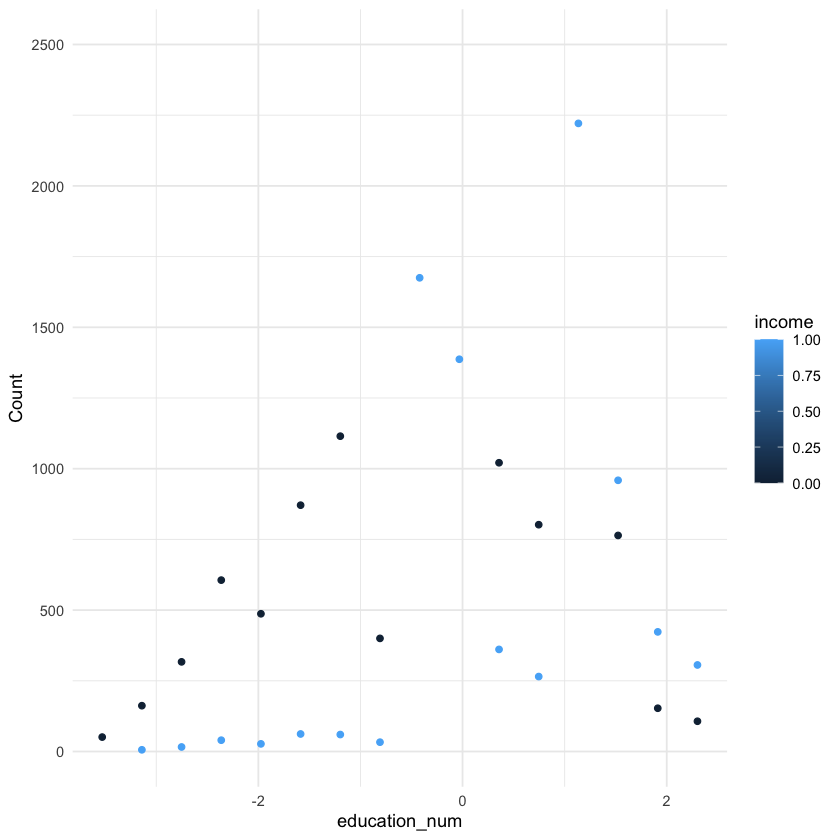

In [69]:
summary_data <-adult_data%>%group_by(education_num,income) %>%summarise(count = n())
ggplot(summary_data, aes(x=education_num, y = count, color =income)) +geom_point()+labs(x = "education_num", y = "Count", color = "income")+theme_minimal()+coord_cartesian(ylim = c(0, 2500))

# Data_cleaning

### summary stat

In [10]:
# Displaying the structure of the dataset
str(adult_data)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  " State-gov" " Self-emp-not-inc" " Private" " Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  " Bachelors" " Bachelors" " HS-grad" " 11th" ...
 $ education_num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital_status: chr  " Never-married" " Married-civ-spouse" " Divorced" " Married-civ-spouse" ...
 $ occupation    : chr  " Adm-clerical" " Exec-managerial" " Handlers-cleaners" " Handlers-cleaners" ...
 $ relationship  : chr  " Not-in-family" " Husband" " Not-in-family" " Husband" ...
 $ race          : chr  " White" " White" " White" " Black" ...
 $ sex           : chr  " Male" " Male" " Male" " Male" ...
 $ capital_gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours_per_week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ native_countr

In [11]:
summary(adult_data)

      age         workclass             fnlwgt         education        
 Min.   :17.00   Length:32561       Min.   :  12285   Length:32561      
 1st Qu.:28.00   Class :character   1st Qu.: 117827   Class :character  
 Median :37.00   Mode  :character   Median : 178356   Mode  :character  
 Mean   :38.58                      Mean   : 189778                     
 3rd Qu.:48.00                      3rd Qu.: 237051                     
 Max.   :90.00                      Max.   :1484705                     
 education_num   marital_status      occupation        relationship      
 Min.   : 1.00   Length:32561       Length:32561       Length:32561      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

### remove missing values by replacing with mode

In [12]:
# Counting missing values for each column
missing_values_per_column <- sapply(adult_data, function(x) sum(is.na(x)))
print(missing_values_per_column)


           age      workclass         fnlwgt      education  education_num 
             0           1836              0              0              0 
marital_status     occupation   relationship           race            sex 
             0           1843              0              0              0 
  capital_gain   capital_loss hours_per_week native_country         income 
             0              0              0            583              0 


In [13]:
# For the 'workclass' and 'occupation' categorical variables, you can replace missing values with the mode.
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

# Replace NA with the most common value (mode)
adult_data$workclass[is.na(adult_data$workclass)] <- getmode(adult_data$workclass)
adult_data$occupation[is.na(adult_data$occupation)] <- getmode(adult_data$occupation)
adult_data$native_country[is.na(adult_data$native_country)] <- getmode(adult_data$native_country)


In [14]:
# Assuming df is your dataframe
numeric_columns <- sapply(adult_data, is.numeric)

# Applying scale function to only numeric columns
adult_data[numeric_columns] <- lapply(adult_data[numeric_columns], scale)



In [15]:
# Check the mean and standard deviation of the numeric columns
sapply(adult_data[numeric_columns], mean)  # Should be very close to 0
sapply(adult_data[numeric_columns], sd)    # Should be close to 1


age         fnlwgt  education_num   capital_gain   capital_loss 
 -4.922883e-17  -1.181928e-16  -9.225547e-17  -1.093754e-15   6.757457e-16 
hours_per_week 
 -5.803793e-16

age         fnlwgt  education_num   capital_gain   capital_loss 
             1              1              1              1              1 
hours_per_week 
             1

### transforming the response var to 0 and 1

In [16]:
# Trim leading and trailing whitespace
adult_data$income <- trimws(adult_data$income)

# Transformation so response is 0 or 1
adult_data$income <- ifelse(adult_data$income == ">50K", 1, 0)

# Check the changes
table(adult_data$income)



    0     1 
24720  7841 

### spliting the dataset

In [17]:
set.seed(123) # Setting a seed for reproducibility

# Assuming 'data' is your dataframe
sample_size <- floor(0.75 * nrow(adult_data)) # Size of the training set: 75% of the data

# Creating a random sample of row indices for the training set
train_indices <- sample(seq_len(nrow(adult_data)), size = sample_size)

# Splitting the data into training and testing sets
train_set <- adult_data[train_indices, ]
test_set <- adult_data[-train_indices, ]


In [18]:
head(train_set,20)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
,"<dbl[,1]>",<chr>,"<dbl[,1]>",<chr>,"<dbl[,1]>",<chr>,<chr>,<chr>,<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>,<dbl>
18847,-0.40919866,Private,-0.83039683,Some-college,-0.03135955,Never-married,Prof-specialty,Own-child,White,Male,-0.1459182,-0.2166562,-0.0354289,United-States,0
18895,-0.92237887,Private,-0.55753083,HS-grad,-0.42005317,Never-married,Adm-clerical,Own-child,Black,Female,-0.1459182,-0.2166562,-0.0354289,United-States,0
26803,0.10398154,Private,0.41072139,7th-8th,-2.36352131,Married-civ-spouse,Craft-repair,Husband,White,Male,-0.1459182,-0.2166562,-0.0354289,El-Salvador,0
25102,-0.18926429,Self-emp-inc,-0.78219217,Some-college,-0.03135955,Divorced,Sales,Unmarried,Asian-Pac-Islander,Male,-0.1459182,-0.2166562,1.1793989,United-States,0
28867,0.32391592,State-gov,-1.52844529,Bachelors,1.13472134,Married-civ-spouse,Prof-specialty,Husband,White,Male,-0.1459182,-0.2166562,-0.2783945,United-States,1
2986,-1.14231324,Private,-0.26594384,Bachelors,1.13472134,Never-married,Other-service,Own-child,White,Female,-0.1459182,-0.2166562,-0.8453141,United-States,0
1842,-0.33588720,Local-gov,-1.20620932,Some-college,-0.03135955,Married-civ-spouse,Transport-moving,Husband,White,Male,-0.1459182,3.7018448,-0.0354289,United-States,0
25718,-0.33588720,Self-emp-not-inc,0.61132778,HS-grad,-0.42005317,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.4644842,-0.2166562,4.0139972,United-States,0
3371,-0.04264137,Private,1.50602243,Prof-school,1.91210860,Married-civ-spouse,Prof-specialty,Husband,White,Male,-0.1459182,-0.2166562,1.5843415,United-States,0


In [37]:
train_set$income <- as.factor(train_set$income)
test_set$income <- as.factor(test_set$income)


# MODEL_TRAINING

### Logistic regression

In [19]:
# fit model using glm
log_model <- glm(income ~ ., data = train_set, family = binomial)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


### feature selection

In [67]:
# Backward selection
best_model <- step(log_model, direction = "backward")


In [ ]:
class(best_model)

In [68]:
summary(best_model)


ERROR: Error in summary(best_model): class name too long in 'summary'


In [21]:
library(leaps)
model<-regsubsets(income ~ ., data=train_set ,method='backward')
summary(model)
reg_summary=summary(model)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


Subset selection object
Call: regsubsets.formula(income ~ ., data = train_set, method = "backward")
97 Variables  (and intercept)
                                          Forced in Forced out
age                                           FALSE      FALSE
workclass Local-gov                           FALSE      FALSE
workclass Never-worked                        FALSE      FALSE
workclass Private                             FALSE      FALSE
workclass Self-emp-inc                        FALSE      FALSE
workclass Self-emp-not-inc                    FALSE      FALSE
workclass State-gov                           FALSE      FALSE
workclass Without-pay                         FALSE      FALSE
fnlwgt                                        FALSE      FALSE
education 11th                                FALSE      FALSE
education 12th                                FALSE      FALSE
education 1st-4th                             FALSE      FALSE
education 5th-6th                             FALSE

In [72]:
reg_summary$rsq
reg_summary$adjr2
reg_summary$cp
reg_summary$bic
reg_summary$aic

[1] 0.05231239 0.11552587 0.17787053 0.21376846 0.23758115 0.26174137 0.28122381
[8] 0.29479365 0.30798158

[1] 0.05227358 0.11545342 0.17776952 0.21363965 0.23742501 0.26155993 0.28101771
[8] 0.29456254 0.30772643

[1] 11842.336  9425.801  7042.507  5671.060  4761.991  3839.626  3096.232
[8]  2579.052  2076.485

[1] -1291.889 -2967.539 -4742.425 -5822.591 -6563.531 -7339.797 -7982.787
[8] -8438.119 -8889.013

NULL

In [23]:
# Assuming 'model' is your regsubsets object from the backward selection
reg_summary <- summary(model)

# Loop through each model size
for(i in 1:length(reg_summary$rsq)) {
  cat("Model with", i, "variables:\n")
  
  # Extract coefficients for model with 'i' variables
  coeffs <- coef(model, id = i)
  
  print(coeffs)
  cat("\n")
}


Model with 1 variables:
           (Intercept) relationship Unmarried 
             0.2594422             -0.2006186 

Model with 2 variables:
                (Intercept) relationship Other-relative 
                  0.2669063                  -0.2254698 
     relationship Unmarried 
                 -0.2080827 

Model with 3 variables:
                (Intercept) relationship Other-relative 
                  0.2545819                  -0.2131454 
     relationship Unmarried           relationship Wife 
                 -0.1957583                   0.2216086 

Model with 4 variables:
                (Intercept) relationship Other-relative 
                 0.25405642                 -0.20679009 
     relationship Unmarried           relationship Wife 
                -0.18849726                  0.21900971 
               capital_loss 
                 0.05945897 

Model with 5 variables:
                (Intercept)         education Bachelors 
                 0.22074849            

### KNN

In [38]:
control <- trainControl(method = "cv", number = 10)
knn_model <- train(income~., data = train_set, method = "knn", trControl = control, preProcess = c("center", "scale"))


Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: native_country Holand-Netherlands”
Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: native_country Holand-Netherlands”
Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: native_country Holand-Netherlands”


In [44]:
summary(knn_model)

            Length Class      Mode     
learn         2    -none-     list     
k             1    -none-     numeric  
theDots       0    -none-     list     
xNames      105    -none-     character
problemType   1    -none-     character
tuneValue     1    data.frame list     
obsLevels     2    -none-     character
param         0    -none-     list     

In [53]:
control <- trainControl(method = "cv", number = 10)
tuneGrid <- expand.grid(k = 1:10)

knn_model <- train(income ~ ., data = train_set, method = "knn", trControl = control, tuneGrid = tuneGrid)

In [55]:
# For KNN
knn_model$bestTune

,k
,<int>
9,9


### Decision tree

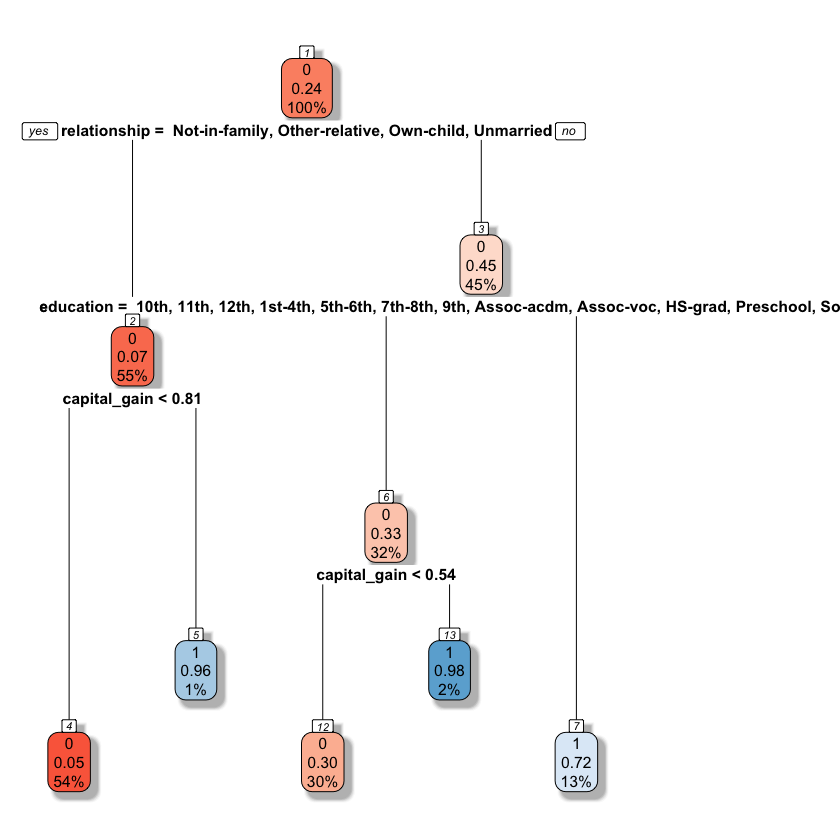

In [39]:
tree_model <- rpart(income ~ ., data = train_set, method = "class")

rpart.plot(tree_model, box.palette = "RdBu", shadow.col = "gray", nn = TRUE)


In [56]:
control <- trainControl(method = "cv", number = 10)
tuneGrid <- expand.grid(cp = seq(0.01, 0.1, by = 0.01))

tree_model <- train(income ~ ., data = train_set, method = "rpart", trControl = control, tuneGrid = tuneGrid)

In [57]:
tree_model$bestTune

,cp
,<dbl>
2,0.02


In [61]:
best_cp <- tree_model$bestTune$cp

In [63]:
opt_tree <- rpart(income ~ ., data = train_set, control = rpart.control(cp = best_cp))

### Model selection

In [64]:
# Logistic Regression Prediction and Evaluation
log_pred <- predict(log_model, newdata = test_set, type = "response")
log_pred_class <- ifelse(log_pred > 0.5, 1, 0)
log_confMat <- confusionMatrix(as.factor(log_pred_class), as.factor(test_set$income))
log_accuracy <- log_confMat$overall['Accuracy']

# KNN Prediction and Evaluation
knn_pred <- predict(knn_model, newdata = test_set)
knn_confMat <- confusionMatrix(knn_pred, test_set$income)
knn_accuracy <- knn_confMat$overall['Accuracy']

# Decision Tree Prediction and Evaluation
tree_pred <- predict(opt_tree, newdata = test_set, type = "class")
tree_confMat <- confusionMatrix(tree_pred, as.factor(test_set$income))
tree_accuracy <- tree_confMat$overall['Accuracy']


In [65]:
accuracy_df

Model,Accuracy
<chr>,<dbl>
Logistic Regression,0.8491586
KNN,0.8272939
Decision Tree,0.8436310


In [66]:
accuracy_df <- data.frame(Model = c("Logistic Regression", "KNN", "Decision Tree"),
                          Accuracy = c(log_accuracy, knn_accuracy, tree_accuracy))

best_model <- accuracy_df[which.max(accuracy_df$Accuracy),]
print(paste("The best model is", best_model$Model, "with an accuracy of", best_model$Accuracy))


[1] "The best model is Logistic Regression with an accuracy of 0.849158580027024"


In [ ]:
# Assuming 'test_set' is your testing dataset
# Making predictions
predictions <- predict(model, newdata=test_set, type="response")

# The predictions are probabilities of the positive class (e.g., 1)
# To classify as 0 or 1 based on a threshold (e.g., 0.5):
predicted_classes <- ifelse(predictions > 0.5, 1, 0)

# You can adjust the threshold based on your specific needs
